# Data Preparation

## split data by year

In [3]:
import pandas as pd
import os

# pd.options.mode.copy_on_write = True


FILE_DIR = 'data_Energy_Germany'
FILE_NAME_PREFIX = 'Realised_Demand_Germany'
FILE_PATHS = [os.path.join(FILE_DIR, file)
              for file in os.listdir(FILE_DIR) if file.startswith(FILE_NAME_PREFIX)]

FILE_PATHS = FILE_PATHS[:1]  # todo: temp

TZ = 'Europe/Berlin'
SEP = ';'


def load_data():
    df = pd.concat((pd.read_csv(file_path, sep=SEP)
                    for file_path in FILE_PATHS), ignore_index=True)
    
    df.drop(['Residual Load [MWh]', 'Pumped Storage [MWh]', 'Date to'], axis=1, inplace=True)
    df.rename(columns={'Date from': 'date_from', 'Total (Grid Load) [MWh]': 'grid_load'}, inplace=True)
    
    # convert to datetime column
    df['date_from'] = pd.to_datetime(df['date_from'], format='%d.%m.%y %H:%M').dt.tz_localize(TZ, ambiguous='infer')
    
    # convert to float column
    df.grid_load = df.grid_load.str.replace('.', '').str.replace(',', '.')  # clean float representation
    df = df.astype({'grid_load': float})

    # report NAs
    for col in df.columns:
        if any(df.date_from.isna()):
            print(f'WARNING: Missing value in column {col} detected!')
    return df

df = load_data()
df.head()

,date_from,grid_load
0,2015-01-01 00:00:00+01:00,11210.00
1,2015-01-01 00:15:00+01:00,11118.75
2,2015-01-01 00:30:00+01:00,11144.75
3,2015-01-01 00:45:00+01:00,11126.75
4,2015-01-01 01:00:00+01:00,11009.50


In [4]:
GRID_LOAD_DICT = dict(zip(df.date_from, df.grid_load))

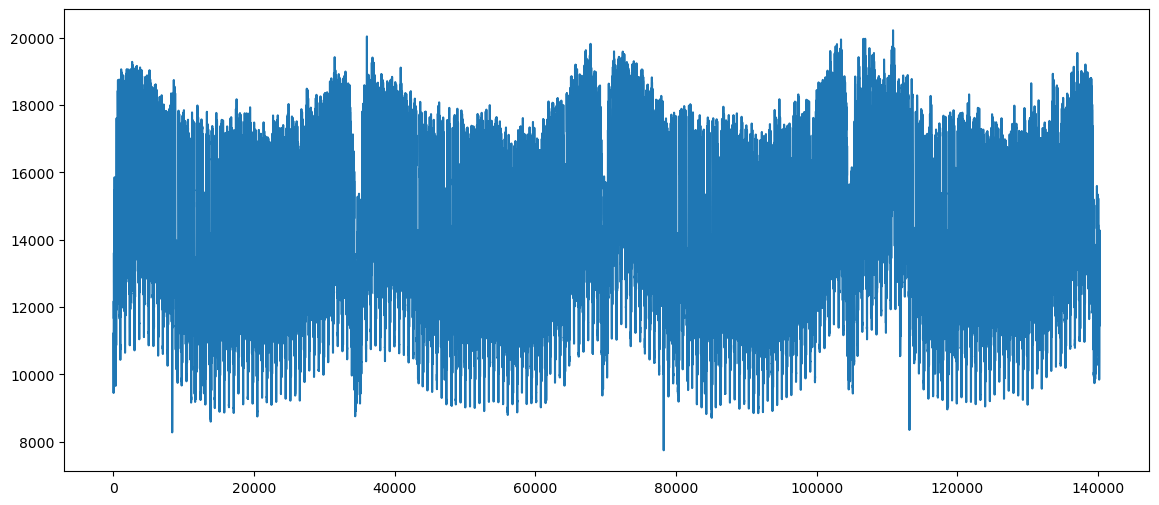

In [5]:
# PLOT DATA

import numpy as np
import matplotlib.pyplot as plt

def plot_data(df):
    data = np.array(df.grid_load)
    
    fig, ax = plt.subplots(figsize=(14,6))
    ax.plot(np.arange(data.size), data)
    plt.show()

plot_data(df)

## categorize days

In [7]:
from holidays.utils import country_holidays

def categorize_days(df):
    german_holidays = country_holidays('DE')
    holiday_dates = set(german_holidays.keys())
    
    def is_sunday_or_holiday(timestamp):
        return timestamp.date() in holiday_dates or timestamp.day_name() == 'Sunday'
    
    def gen_saturday_col(df):
        return df.date_from.map(lambda ts: ts.day_name() == 'Saturday') & ~df.cat_is_sunday_or_holiday
    
    df = df.assign(cat_is_sunday_or_holiday=df.date_from.map(is_sunday_or_holiday))
    df = df.assign(cat_is_saturday_and_not_holiday=gen_saturday_col(df))
    df = df.assign(cat_is_workday=(~df.cat_is_sunday_or_holiday & ~df.cat_is_saturday_and_not_holiday))
    return df

df = categorize_days(df)
df.head()

,date_from,grid_load,cat_is_sunday_or_holiday,cat_is_saturday_and_not_holiday,cat_is_workday
0,2015-01-01 00:00:00+01:00,11210.00,False,False,True
1,2015-01-01 00:15:00+01:00,11118.75,False,False,True
2,2015-01-01 00:30:00+01:00,11144.75,False,False,True
3,2015-01-01 00:45:00+01:00,11126.75,False,False,True
4,2015-01-01 01:00:00+01:00,11009.50,False,False,True


## add heating period

In [9]:
def add_heating_period(df):
    # heating period is approx. from October to March
    month_april, month_september = 4, 9
    non_heating_period = range(month_april, month_september+1)
    df = df.assign(cat_is_heating_period=df.date_from.map(lambda ts: ts.month not in non_heating_period))
    return df

df = add_heating_period(df)
df.head()

,date_from,grid_load,cat_is_sunday_or_holiday,cat_is_saturday_and_not_holiday,cat_is_workday,cat_is_heating_period
0,2015-01-01 00:00:00+01:00,11210.00,False,False,True,True
1,2015-01-01 00:15:00+01:00,11118.75,False,False,True,True
2,2015-01-01 00:30:00+01:00,11144.75,False,False,True,True
3,2015-01-01 00:45:00+01:00,11126.75,False,False,True,True
4,2015-01-01 01:00:00+01:00,11009.50,False,False,True,True


## add lagged time stamps

In [46]:
def add_timedelta(ts, td):
    # based on: https://www.hacksoft.io/blog/handling-timezone-and-dst-changes-with-python
    ts_utc = ts.astimezone('UTC')
    ts_shifted_utc = ts_utc + td
    ts_shifted = ts_shifted_utc.astimezone(TZ)
    dst_offset_diff = ts.dst() - ts_shifted.dst()
    ts_shifted += dst_offset_diff
    return ts_shifted

add_timedelta(df.date_from[0], relativedelta(years=+1))

Timestamp('2016-01-01 00:00:00+0100', tz='Europe/Berlin')

In [25]:
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from functools import partial


# note: leap year handled by reusing values from 28th of February

# use *positive* timedeltas or relativedeltas. Use relativedeltas only for deltas >= 1 year.
LAGS = {
    'last_year': relativedelta(years=+1),
    'last_week': timedelta(weeks=+1),
    'yesterday': timedelta(days=+1),
    'last_hour': timedelta(hours=+1),
}
DF_POINTS_PER_HOUR = 4

TS_COLS = [f'ts_{col_name}' for col_name in LAGS]

def add_lagged_ts(df, lags):
    df.rename(columns={'date_from': 'ts_pred', 'grid_load': 'load_to_pred'}, inplace=True)

    for col_name, lag in lags.items():
        if isinstance(lag, relativedelta):  # check this way since relativedelta's "day" attribute works differently
            shifted = df.ts_pred.map(partial(add_timedelta, td=-lag))
        elif lag.days < 1:
            num_hours = lag.total_seconds() // 3600
            shifted = df.ts_pred.shift(round(num_hours * DF_POINTS_PER_HOUR))
        else:
            shifted = df.ts_pred.map(partial(add_timedelta, td=-lag))
        new_col_data = {f'ts_{col_name}': shifted}
        df = df.assign(**new_col_data)
    
    df.dropna(inplace=True, ignore_index=True)
    return df

def sub_one_year(ts):
    # todo: decide how to handle leap years
    return add_timedelta(ts, timedelta(days=-365))

def add_timedelta(ts, td):
    # based on: https://www.hacksoft.io/blog/handling-timezone-and-dst-changes-with-python
    ts_utc = ts.astimezone('UTC')
    ts_shifted_utc = ts_utc + td
    ts_shifted = ts_shifted_utc.astimezone(TZ)
    dst_offset_diff = ts.dst() - ts_shifted.dst()
    ts_shifted += dst_offset_diff
    return ts_shifted


df = add_lagged_ts(df, LAGS)
df.head()

,ts_pred,load_to_pred,cat_is_sunday_or_holiday,cat_is_saturday_and_not_holiday,cat_is_workday,cat_is_heating_period,ts_last_week,ts_yesterday,ts_last_hour
0,2015-01-01 01:00:00+01:00,11009.50,False,False,True,True,2014-12-25 01:00:00+01:00,2014-12-31 01:00:00+01:00,2015-01-01 00:00:00+01:00
1,2015-01-01 01:15:00+01:00,10923.25,False,False,True,True,2014-12-25 01:15:00+01:00,2014-12-31 01:15:00+01:00,2015-01-01 00:15:00+01:00
2,2015-01-01 01:30:00+01:00,10817.00,False,False,True,True,2014-12-25 01:30:00+01:00,2014-12-31 01:30:00+01:00,2015-01-01 00:30:00+01:00
3,2015-01-01 01:45:00+01:00,10705.00,False,False,True,True,2014-12-25 01:45:00+01:00,2014-12-31 01:45:00+01:00,2015-01-01 00:45:00+01:00
4,2015-01-01 02:00:00+01:00,10650.00,False,False,True,True,2014-12-25 02:00:00+01:00,2014-12-31 02:00:00+01:00,2015-01-01 01:00:00+01:00


## remove OOB timestamps (due to shifting)

In [7]:
def remove_oob_ts(df, lags):
    ts_with_data_min, ts_with_data_max = df.ts_pred.min(), df.ts_pred.max()
    for col in TS_COLS:
        out_of_bounds_index = df[(df[col] < ts_with_data_min) | (df[col] > ts_with_data_max)].index
        df.drop(index=out_of_bounds_index, inplace=True)
    df = df.reset_index(drop=True)
    return df

df = remove_oob_ts(df, LAGS)
df

,ts_pred,load_to_pred,is_sunday_or_holiday,is_saturday_and_not_holiday,is_workday,is_heating_period,ts_last_week,ts_yesterday,ts_last_hour
0,2023-01-08 01:00:00+01:00,10375.25,True,False,False,True,2023-01-01 01:00:00+01:00,2023-01-07 01:00:00+01:00,2023-01-08 00:00:00+01:00
1,2023-01-08 01:15:00+01:00,10232.75,True,False,False,True,2023-01-01 01:15:00+01:00,2023-01-07 01:15:00+01:00,2023-01-08 00:15:00+01:00
2,2023-01-08 01:30:00+01:00,10189.25,True,False,False,True,2023-01-01 01:30:00+01:00,2023-01-07 01:30:00+01:00,2023-01-08 00:30:00+01:00
3,2023-01-08 01:45:00+01:00,10119.50,True,False,False,True,2023-01-01 01:45:00+01:00,2023-01-07 01:45:00+01:00,2023-01-08 00:45:00+01:00
4,2023-01-08 02:00:00+01:00,10070.50,True,False,False,True,2023-01-01 02:00:00+01:00,2023-01-07 02:00:00+01:00,2023-01-08 01:00:00+01:00
...,...,...,...,...,...,...,...,...,...
34359,2023-12-31 22:45:00+01:00,10782.00,True,False,False,True,2023-12-24 22:45:00+01:00,2023-12-30 22:45:00+01:00,2023-12-31 21:45:00+01:00
34360,2023-12-31 23:00:00+01:00,10753.75,True,False,False,True,2023-12-24 23:00:00+01:00,2023-12-30 23:00:00+01:00,2023-12-31 22:00:00+01:00
34361,2023-12-31 23:15:00+01:00,10606.75,True,False,False,True,2023-12-24 23:15:00+01:00,2023-12-30 23:15:00+01:00,2023-12-31 22:15:00+01:00
34362,2023-12-31 23:30:00+01:00,10495.75,True,False,False,True,2023-12-24 23:30:00+01:00,2023-12-30 23:30:00+01:00,2023-12-31 22:30:00+01:00


## timestamps to grid loads

In [8]:
def ts_to_loads(df):
    for lag_name, ts_col_name in zip(LAGS, TS_COLS):
        load = df[ts_col_name].map(lambda ts: GRID_LOAD_DICT[ts])
        new_col_data = {f'load_{lag_name}': load}
        df = df.assign(**new_col_data)
    
    # remove unneeded time stamp columns
    df.drop(TS_COLS, axis=1, inplace=True)
    return df

df = ts_to_loads(df)
df

,ts_pred,load_to_pred,is_sunday_or_holiday,is_saturday_and_not_holiday,is_workday,is_heating_period,load_last_week,load_yesterday,load_last_hour
0,2023-01-08 01:00:00+01:00,10375.25,True,False,False,True,9473.50,10382.25,10807.25
1,2023-01-08 01:15:00+01:00,10232.75,True,False,False,True,9448.00,10382.75,10703.75
2,2023-01-08 01:30:00+01:00,10189.25,True,False,False,True,9550.25,10255.75,10627.00
3,2023-01-08 01:45:00+01:00,10119.50,True,False,False,True,9463.75,10170.50,10510.25
4,2023-01-08 02:00:00+01:00,10070.50,True,False,False,True,9358.50,10090.75,10375.25
...,...,...,...,...,...,...,...,...,...
34359,2023-12-31 22:45:00+01:00,10782.00,True,False,False,True,11116.00,10752.00,11134.50
34360,2023-12-31 23:00:00+01:00,10753.75,True,False,False,True,11023.50,10487.25,11191.50
34361,2023-12-31 23:15:00+01:00,10606.75,True,False,False,True,10856.25,10287.75,11117.25
34362,2023-12-31 23:30:00+01:00,10495.75,True,False,False,True,10688.25,10163.50,11008.50


In [9]:
def save_df(df, filename='data.pkl'):
    df.to_pickle(filename)

save_df(df)

In [ ]:
# stop for automatic run
1/0

# Linear Regression

## load data

In [10]:
# import importlib
# import energy_test

# importlib.reload(energy_test)

In [11]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt

import numpy as np
from sklearn.model_selection import train_test_split

from energy_test import df_to_input_output



def df_to_input_output(df, with_ts=False):
    input_cols = [
        'load_last_week',
        'load_yesterday',
        'load_last_hour',
    ]
    output_cols = ['load_to_pred']
    ts_cols = ['ts_pred']
    # input_cols = [col for col in df.columns
    #               if col not in output_cols + ts_cols]
    
    X = np.array(df[input_cols], dtype=float).reshape(-1, len(input_cols))  # (n_samples, n_features)
    y = np.array(df[output_cols], dtype=float).reshape(-1, len(output_cols))  # (n_samples, n_targets)
    ts = np.array(df[ts_cols]).reshape(-1, len(ts_cols))
    
    return (X, y, ts) if with_ts else (X, y)


df = pd.read_pickle('data.pkl')
X, y = df_to_input_output(df)  # convert df to np arrays
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((17182, 3), (17182, 3), (17182, 1), (17182, 1))

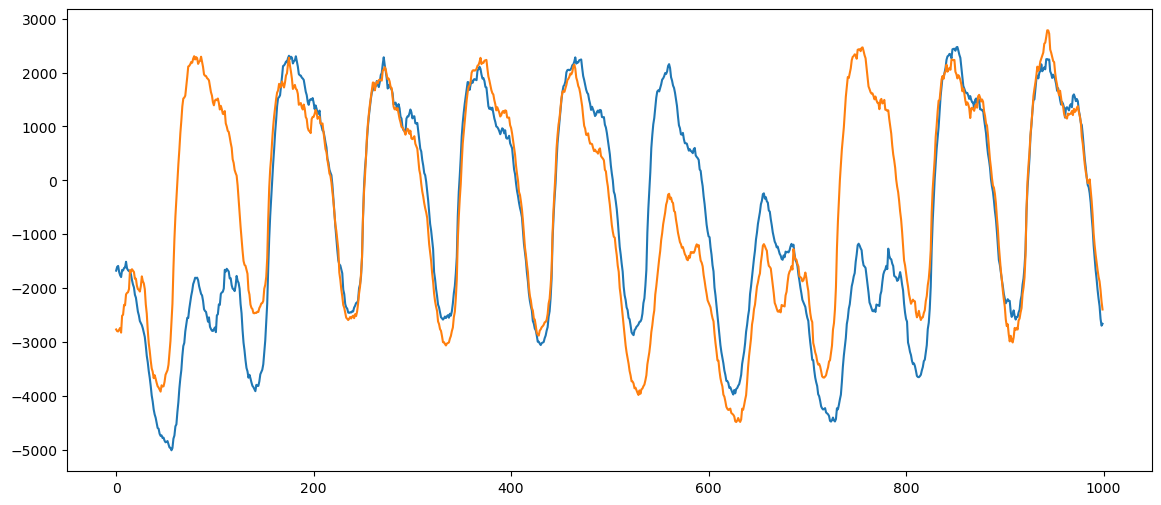

In [12]:
def my_plot():
    lim = 1000
    # X_col = 'load_last_hour'
    # y_col = 'load_to_pred'
    # X, y = df[X_col][-lim:], df[y_col][-lim:]

    X = X_train[:, 1]  # week, yesterday, hour
    y = y_train

    X = (X - X.mean())[-lim:]  #/ X.std()
    y = (y - y.mean())[-lim:]  #/ y.std()
    
    x_plot = np.arange(y.size)

    plt.figure(figsize=(14,6))
    plt.plot(x_plot, X, )
    plt.plot(x_plot, y, )
    plt.show()

my_plot()

## Run LinReg

Mean squared error relative to mean true value: 17.80301


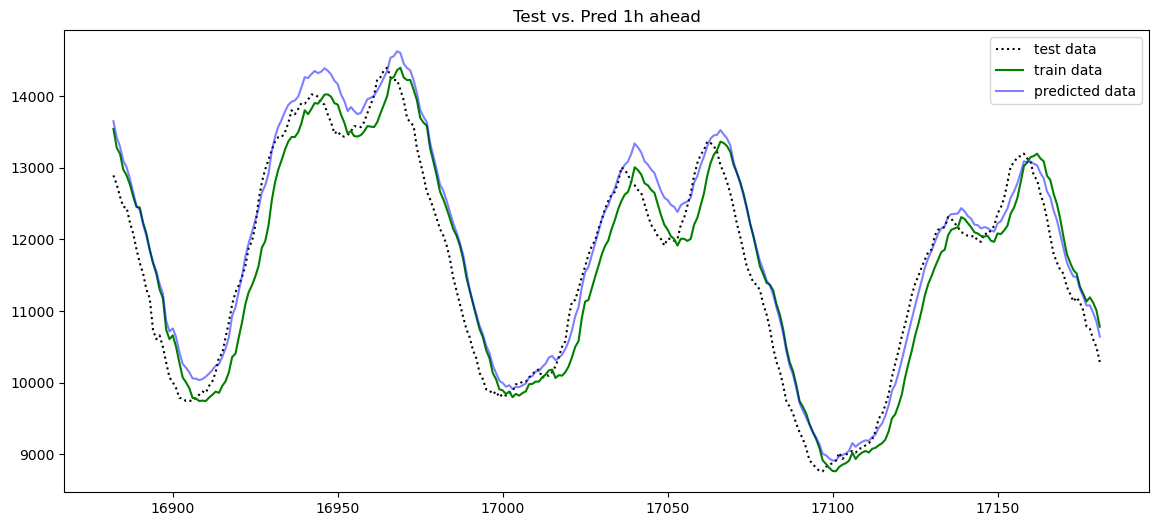

In [13]:
# TRAIN AND PLOTS

n_points = 300

regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

print(f"Mean squared error relative to mean true value: {mean_squared_error(y_test, y_pred) / y_test.mean():.5f}")

def plot():
    fig, ax = plt.subplots(figsize=(14,6))
    x_plot = np.arange(X_test.shape[0])
    ax.plot(x_plot[-n_points:], y_test[-n_points:], color="black", label='test data', linestyle='dotted')
    ax.plot(x_plot[-n_points:], X_test[-n_points:, 2], color="green", label='train data')
    ax.plot(x_plot[-n_points:], y_pred[-n_points:], color="blue", label='predicted data', alpha=0.5)
    plt.title('Test vs. Pred 1h ahead')
    plt.legend()
    plt.show()

plot()

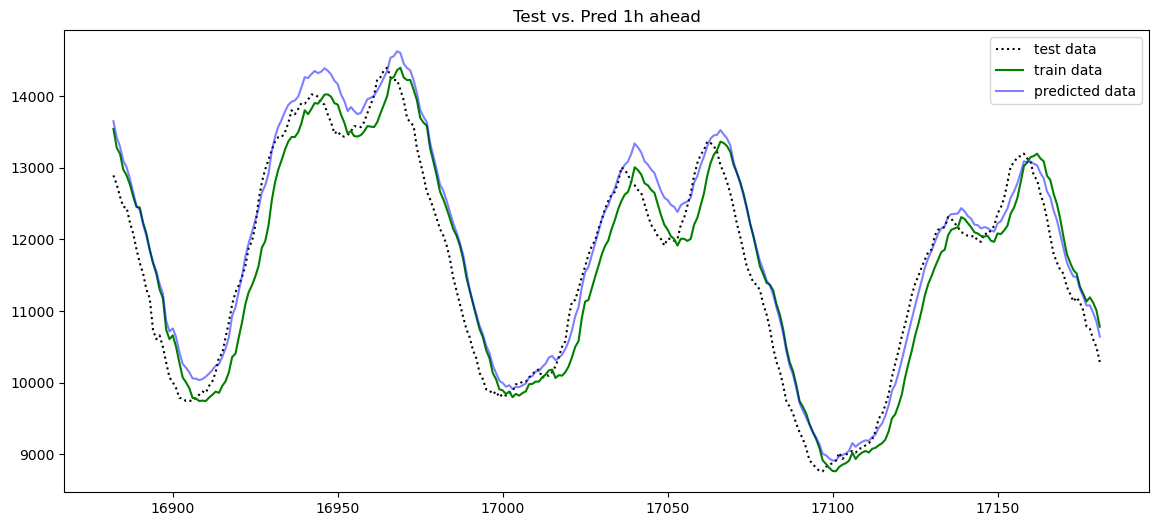

In [14]:
def plot():
    fig, ax = plt.subplots(figsize=(14,6))
    x_plot = np.arange(X_test.shape[0])
    ax.plot(x_plot[-n_points:], y_test[-n_points:], color="black", label='test data', linestyle='dotted')
    ax.plot(x_plot[-n_points:], X_test[-n_points:, 2], color="green", label='train data')
    ax.plot(x_plot[-n_points:], y_pred[-n_points:], color="blue", label='predicted data', alpha=0.5)
    plt.title('Test vs. Pred 1h ahead')
    plt.legend()
    plt.show()

plot()